In [26]:
from pyrpl import Pyrpl
from pyrpl.async_utils import sleep

import numpy as np
from scipy.signal import find_peaks

import matplotlib.pyplot as plt

In [27]:
class Laser:
    def __init__(self):
        self.transmission = None
        self.peaks = None

In [28]:
p = Pyrpl(config="scanning-cavity-lock")
r = p.rp

INFO:pyrpl:All your PyRPL settings will be saved to the config file
    C:\Users\ThompsonLab\pyrpl_user_dir\config\scanning-cavity-lock.yml
If you would like to restart PyRPL with these settings, type "pyrpl.exe scanning-cavity-lock" in a windows terminal or 
    from pyrpl import Pyrpl
    p = Pyrpl('scanning-cavity-lock')
in a python terminal.
INFO:pyrpl.redpitaya:Successfully connected to Redpitaya with hostname 10.0.5.11.


In [94]:
WAVELENGTH = 389.9e-9 * 2

DRIVE_AMPLITUDE = 0.5
DRIVE_FREQUENCY = 1e3

In [85]:
r.scope.trigger_source = 'asg0'
r.scope.trigger_delay = 0
r.scope.threshold = 0.1
r.scope.hysteresis = 0.01

r.scope.duration = 2/DRIVE_FREQUENCY
r.scope.trace_average = 1000

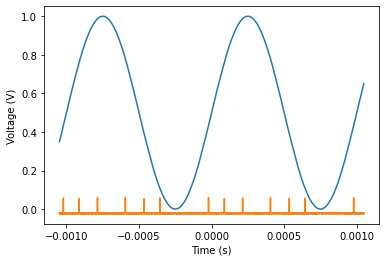

Phase Shift: 21.93408000000001°
Voltage Difference: 0.3308897814461499 V
Position Drive Amplitude: 2.357 um


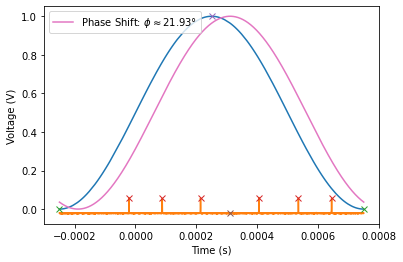

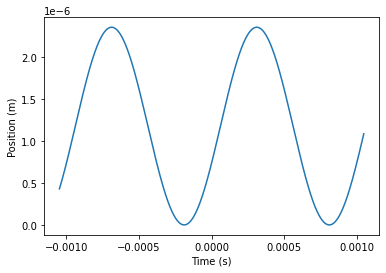

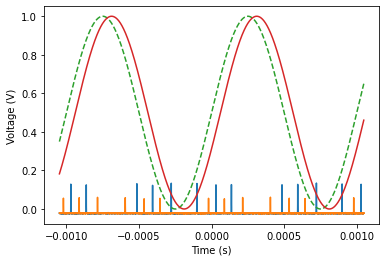

In [103]:
r.scope.input1 = 'asg0'
r.scope.input2 = 'in2'

trace = r.scope.curve_async()
r.asg0.setup(frequency=DRIVE_FREQUENCY, amplitude=DRIVE_AMPLITUDE, offset=DRIVE_AMPLITUDE, waveform='sin', trigger_source='immediately', output_direct='out1')
sleep(0.01)
drive_trace, cavity_trace = trace.result()

plt.plot(r.scope.times, drive_trace)
plt.plot(r.scope.times, cavity_trace)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.show()

drive_troughs, _ = find_peaks(1 - drive_trace)
drive_center, _ = find_peaks(drive_trace[drive_troughs[0]:drive_troughs[1]])
drive_center = drive_troughs[0] + drive_center[0]
cavity_peaks, _ = find_peaks(cavity_trace[drive_troughs[0]:drive_troughs[1]], height=0.01)
cavity_peaks = drive_troughs[0] + cavity_peaks
cavity_center = np.rint(np.mean(cavity_peaks)).astype(int)
center_difference = r.scope.times[cavity_center] - r.scope.times[drive_center]
phase_shift = 360 * DRIVE_FREQUENCY * center_difference
print(f"Phase: {phase_shift}°")

shifted_drive = DRIVE_AMPLITUDE * np.sin(2*np.pi*DRIVE_FREQUENCY*r.scope.times - (phase_shift * 2*np.pi/360)) + DRIVE_AMPLITUDE
voltage_difference = shifted_drive[cavity_peaks[1]] - shifted_drive[cavity_peaks[0]]
# print(f"Voltage Difference: {voltage_difference} V")

amplitude = (WAVELENGTH)/(voltage_difference)
print(f"Amplitude: {amplitude*1e6:.3f} um")

position_drive = amplitude * shifted_drive

plt.plot(r.scope.times[drive_troughs[0]:drive_troughs[1]], drive_trace[drive_troughs[0]:drive_troughs[1]])
plt.plot(r.scope.times[drive_troughs[0]:drive_troughs[1]], cavity_trace[drive_troughs[0]:drive_troughs[1]])
plt.plot(r.scope.times[drive_troughs], drive_trace[drive_troughs], 'x')
plt.plot(r.scope.times[cavity_peaks], cavity_trace[cavity_peaks], 'x')
plt.plot(r.scope.times[drive_center], drive_trace[drive_center], 'x')
plt.plot(r.scope.times[cavity_center], cavity_trace[cavity_center], 'x')
plt.plot(r.scope.times[drive_troughs[0]:drive_troughs[1]], shifted_drive[drive_troughs[0]:drive_troughs[1]], label=f"Phase Shift: $\\phi\\approx{phase_shift:.2f}$°")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()
plt.show()

plt.plot(r.scope.times, position_drive)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.show()

r.scope.input1 = 'in1'
r.scope.input2 = 'in2'

trace = r.scope.curve_async()
r.asg0.setup(frequency=DRIVE_FREQUENCY, amplitude=DRIVE_AMPLITUDE, offset=DRIVE_AMPLITUDE, waveform='sin', trigger_source='immediately', output_direct='out1')
sleep(0.01)
control_laser = Laser()
target_lasers = [Laser()]
control_laser.transmission, target_lasers[0].transmission = trace.result()

for laser in [control_laser] + target_lasers:    
    plt.plot(r.scope.times, laser.transmission)
plt.plot(r.scope.times, DRIVE_AMPLITUDE * np.sin(2*np.pi*DRIVE_FREQUENCY*r.scope.times) + DRIVE_AMPLITUDE, '--')
plt.plot(r.scope.times, DRIVE_AMPLITUDE * np.sin(2*np.pi*DRIVE_FREQUENCY*r.scope.times - ((phase_shift) * 2*np.pi/360)) + DRIVE_AMPLITUDE)

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

plt.show()

In [ ]:
# in2 is 389.9*2 nm
# in1 is 
# 1.5 GHz is FSR